# Introduction to Neural Networks with PyTorch

### Typical workflow
Define Dataset, Dataloader -> Define Model -> Train -> Predict

## Dataset and Dataloader

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as tf

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=tf.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=tf.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/home/ubuntu/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Dataset stores the samples and their corresponding labels while DataLoader wraps an iterable around the dataset

- Batch size = number of datasamples propogated before parameters are updated

In [2]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [3]:
# Using the dataloader

loader = enumerate(train_dl)
batch, (x,y) = next(loader)
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


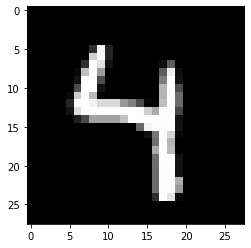

tensor(4)


In [4]:
import matplotlib.pyplot as plt
plt.imshow(x[0][0], cmap='gray')
plt.show()
print(y[0])

### Model (MLP)
- Model does not return probabilities in this case

In [5]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return x

In [10]:
# Looking at models outputs using a random input tensor
def test():
    model = MLP()
    x = torch.randn(1, 1, 28, 28)
    with torch.no_grad():
        y = model(x)
    print(y.shape, y)
    
    # evaluating probabilites
    print(y.argmax(1))
    
test()

torch.Size([1, 10]) tensor([[0.0165, 0.0000, 0.0752, 0.0000, 0.0000, 0.0000, 0.0196, 0.0000, 0.0000,
         0.0489]])
tensor([2])


## Training the model

#### Hyperparameters
- adjustable params that you control optimisation process

- Epochs = number of times to iterate over dataset
- Learning Rate= how much to update the model paramters at each epoch

In [7]:
LR = 1e-3
EPOCHS = 20
loss_fn = nn.CrossEntropyLoss()
model = MLP()
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=LR)
DEVICE = 'cuda'

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device=DEVICE)
        y = y.to(device=DEVICE)
        #compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%200 ==0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device=DEVICE)
            y = y.to(device=DEVICE)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
model = model.to(device=DEVICE)

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n ++++++++++++++++++++++++++++++++++++++++++++++++")
    train_loop(train_dl, model, loss_fn, optimizer)
    test_loop(test_dl, model, loss_fn)
print("Done!")

Epoch 1
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 2.306325  [    0/60000]
loss: 1.342154  [12800/60000]
loss: 1.332084  [25600/60000]
loss: 1.196780  [38400/60000]
loss: 1.231492  [51200/60000]
Test Error: 
 Accuracy: 48.1%, Avg loss: 1.233136 

Epoch 2
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 1.083503  [    0/60000]
loss: 1.107372  [12800/60000]
loss: 1.260818  [25600/60000]
loss: 1.215215  [38400/60000]
loss: 1.372461  [51200/60000]
Test Error: 
 Accuracy: 48.2%, Avg loss: 1.234239 

Epoch 3
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 1.190059  [    0/60000]
loss: 1.298509  [12800/60000]
loss: 1.223770  [25600/60000]
loss: 1.385965  [38400/60000]
loss: 1.265172  [51200/60000]
Test Error: 
 Accuracy: 48.3%, Avg loss: 1.224670 

Epoch 4
 ++++++++++++++++++++++++++++++++++++++++++++++++
loss: 1.050547  [    0/60000]
loss: 1.010642  [12800/60000]
loss: 1.153009  [25600/60000]
loss: 1.487010  [38400/60000]
loss: 1.135774  [51200/60000]
Test Error: 

## Predicting classes
- Using our trained model to predict 

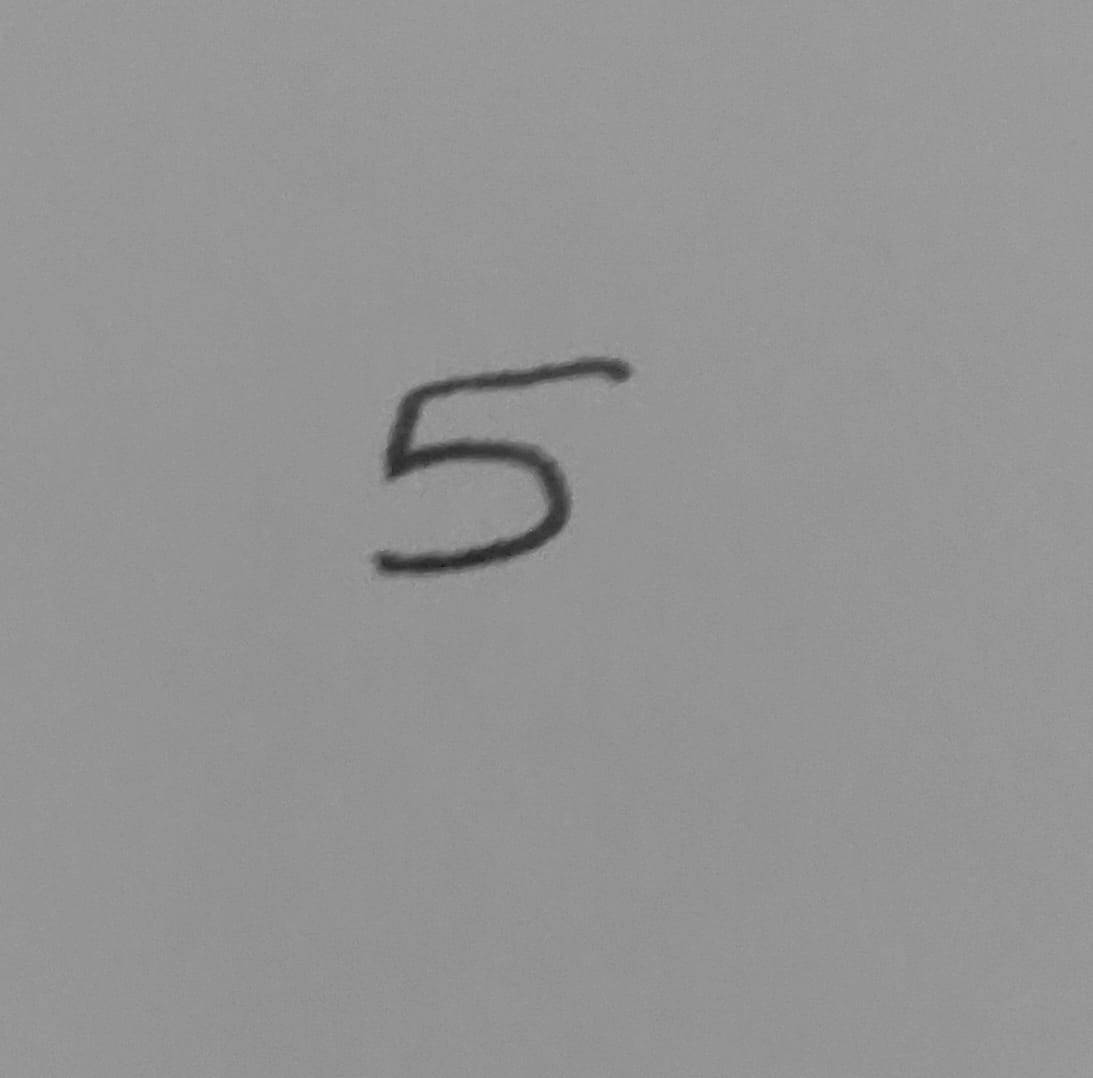

In [11]:
from PIL import Image

image = Image.open('./topredict.jpeg').convert("L")
image.show()

In [16]:
# https://pytorch.org/vision/stable/transforms.html
transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((28,28))
])

image_tensor = transform(image)
image_tensor.shape

torch.Size([1, 28, 28])

In [17]:
image_tensor = image_tensor.resize(1, 1, 28, 28)
image_tensor = image_tensor.to(device=DEVICE)
pred = model(image_tensor)
    
print(torch.argmax(pred))

tensor(8, device='cuda:0')
